# Test Pretrained CNN Model

In [1]:
import sys
sys.path.append(r'/home/lab/Documents/bohao/code/uab')
import os
import scipy.misc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import uabDataReader
import util_functions
from bohaoCustom import uabMakeNetwork_UNet

### System Definitions

In [2]:
batch_size = 5                     # batch size to load at testing
input_size = [572, 572]            # test patch size, no need to be same as training
tile_size = [5000, 5000]           # test image size
file_dir = r'/media/ei-edl01/data/uab_datasets/inria/data/Original_Tiles'  # path to test image
file_name = [['austin1_RGB.tif']]  # test image list, should be a list of lists where the inner list is each image file
pre_trained_model_dir = r'/home/lab/Documents/bohao/code/sis/test/models/UnetInria_fr_mean_reduced/' \
                        r'UnetInria_fr_mean_reduced_EP-100_DS-60.0_LR-0.0001' # path to pretrained model
IMG_MEAN = np.array((109.629784946, 114.94964751, 102.778073453), dtype=np.float32) # RGB mean of all Inria images

### Make Network

In [3]:
# define place holder
X = tf.placeholder(tf.float32, shape=[None, input_size[0], input_size[1], 3], name='X')
y = tf.placeholder(tf.int32, shape=[None, input_size[0], input_size[1], 1], name='y')
mode = tf.placeholder(tf.bool, name='mode')
# define network class
model = uabMakeNetwork_UNet.UnetModelCrop({'X':X, 'Y':y},
                                          trainable=mode,
                                          input_size=input_size,
                                          batch_size=5)
# make graph
model.create_graph('X', class_num=2)

### Prepare DataReader

In [4]:
reader = uabDataReader.ImageLabelReader(gtInds=[0],                 # no need at testing
                                        dataInds=[0],               # no need at testing
                                        nChannels=3,                # RGB images have 3 channels
                                        parentDir=file_dir,
                                        chipFiles=file_name,
                                        chip_size=input_size,
                                        tile_size=tile_size,
                                        batchSize=batch_size,
                                        block_mean=IMG_MEAN,
                                        overlap=model.get_overlap(),# overlap between patches
                                        padding=np.array((model.get_overlap()/2, model.get_overlap()/2)), # padding over whole tile
                                        isTrain=False)
rManager = reader.readManager

### Run on Test Image

In [5]:
pred = model.run(pre_trained_model_dir, rManager, tile_size, input_size)

INFO:tensorflow:Restoring parameters from /home/lab/Documents/bohao/code/sis/test/models/UnetInria_fr_mean_reduced/UnetInria_fr_mean_reduced_EP-100_DS-60.0_LR-0.0001/model.ckpt-160000
loaded /home/lab/Documents/bohao/code/sis/test/models/UnetInria_fr_mean_reduced/UnetInria_fr_mean_reduced_EP-100_DS-60.0_LR-0.0001/model.ckpt-160000


### Evaluate Results

In [6]:
truth_label_img = scipy.misc.imread(os.path.join(file_dir, 'austin1_GT.tif'))
original_img = scipy.misc.imread(os.path.join(file_dir, file_name[0][0]))
iou = util_functions.iou_metric(truth_label_img, pred)
print(iou)

0.805378076834


### Visulaize Results

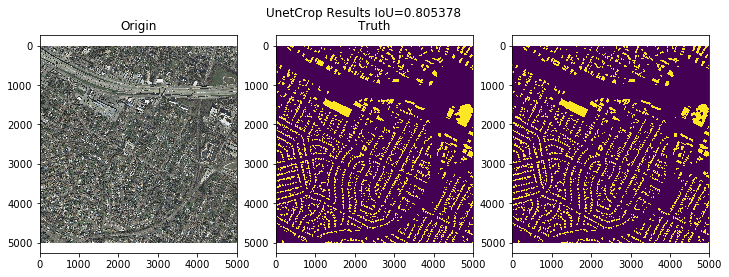

In [7]:
plt.figure(figsize=(12, 4))
ax1 = plt.subplot(131)
ax1.imshow(original_img)
plt.title('Origin')
ax2 = plt.subplot(132, sharex=ax1, sharey=ax1)
ax2.imshow(truth_label_img)
plt.title('Truth')
ax3 = plt.subplot(133, sharex=ax1, sharey=ax1)
ax3.imshow(pred)
plt.suptitle('{} Results IoU={:3f}'.format(model.model_name, iou))
plt.show()